Here I analyse the kind of noise present in the background, dark frames.

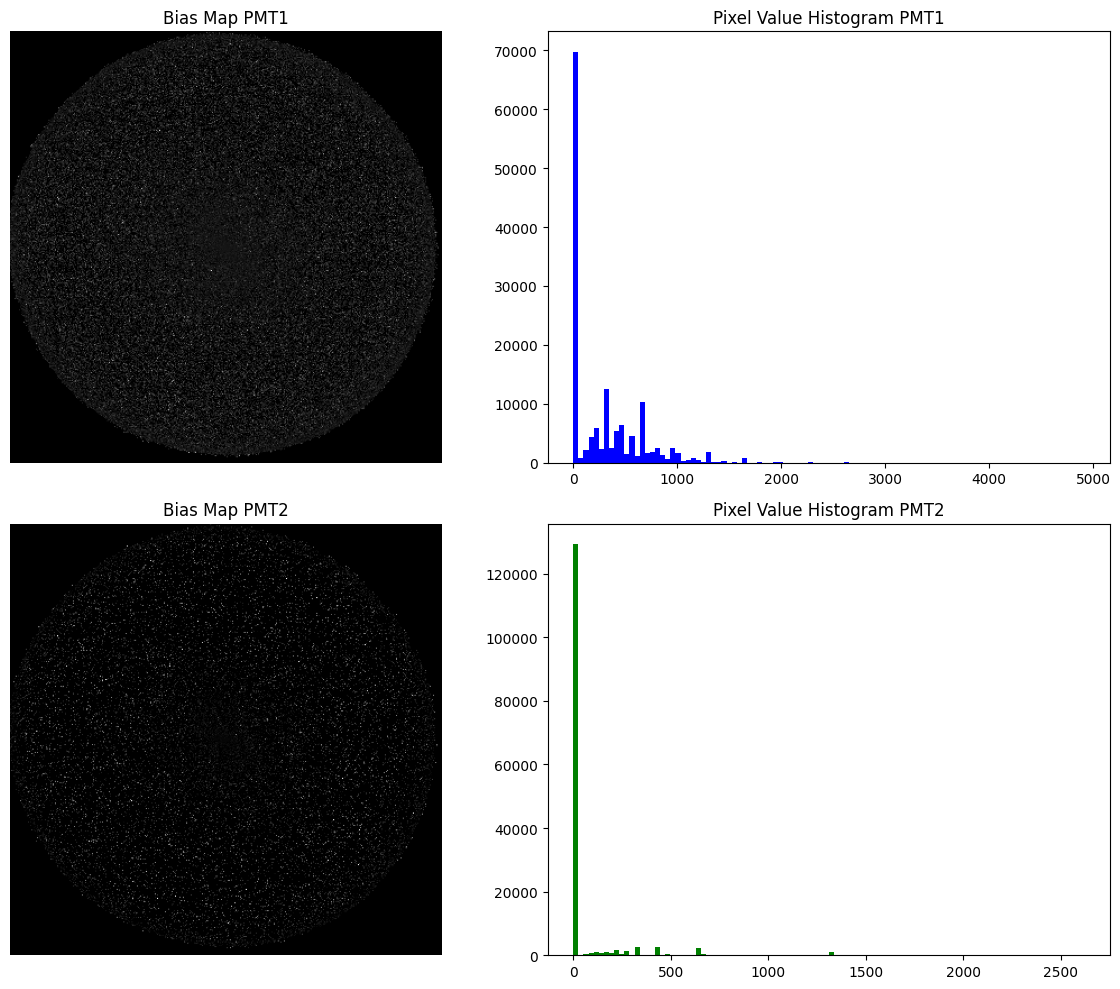

Bias maps created and saved successfully!


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Folder where your structured data is (ROI_1, ROI_2, etc.)
structured_folder = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/structured_darkframes_endoscopic_scans'

# Initialize lists to hold images
pmt1_images = []
pmt2_images = []

# Traverse through each ROI folder
for roi_folder in sorted(os.listdir(structured_folder)):
    roi_path = os.path.join(structured_folder, roi_folder)
    if os.path.isdir(roi_path):
        for file in os.listdir(roi_path):
            if file.endswith('.tiff'):
                file_path = os.path.join(roi_path, file)
                img = np.array(Image.open(file_path)).astype(np.float32)

                if 'PMT1' in file:
                    pmt1_images.append(img)
                elif 'PMT2' in file:
                    pmt2_images.append(img)

# Stack across channels and compute pixel-wise average
pmt1_stack = np.stack(pmt1_images, axis=0)
pmt2_stack = np.stack(pmt2_images, axis=0)

bias_map_pmt1 = np.mean(pmt1_stack, axis=0)
bias_map_pmt2 = np.mean(pmt2_stack, axis=0)

# Save the bias maps
# bias_maps_folder = os.path.join('/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset', 'bias_maps')
# os.makedirs(bias_maps_folder, exist_ok=True)

# Image.fromarray(bias_map_pmt1.astype(np.uint16)).save(os.path.join(bias_maps_folder, 'bias_map_PMT1.tiff'))
# Image.fromarray(bias_map_pmt2.astype(np.uint16)).save(os.path.join(bias_maps_folder, 'bias_map_PMT2.tiff'))

# Plot bias maps and their histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# PMT1 Bias Map
axs[0, 0].imshow(bias_map_pmt1, cmap='gray')
axs[0, 0].set_title('Bias Map PMT1')
axs[0, 0].axis('off')

# PMT1 Histogram
axs[0, 1].hist(bias_map_pmt1.flatten(), bins=100, color='blue')
axs[0, 1].set_title('Pixel Value Histogram PMT1')

# PMT2 Bias Map
axs[1, 0].imshow(bias_map_pmt2, cmap='gray')
axs[1, 0].set_title('Bias Map PMT2')
axs[1, 0].axis('off')

# PMT2 Histogram
axs[1, 1].hist(bias_map_pmt2.flatten(), bins=100, color='green')
axs[1, 1].set_title('Pixel Value Histogram PMT2')

plt.tight_layout()
plt.show()

print("Bias maps created and saved successfully!")


Filtered PMT1 - Min: 29.780000686645508, Max: 1310.6500244140625
Filtered PMT2 - Min: 9.619999885559082, Max: 1310.699951171875


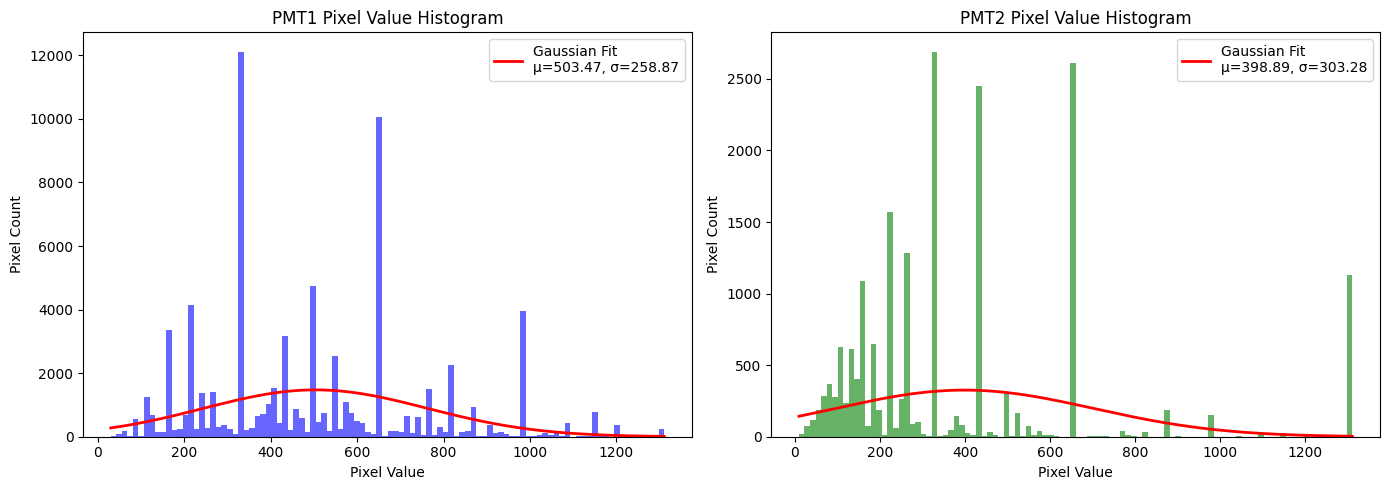

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import norm

# Remove 0-valued pixels
non_zero_pmt1 = bias_map_pmt1[bias_map_pmt1 > 0].flatten()
non_zero_pmt2 = bias_map_pmt2[bias_map_pmt2 > 0].flatten()

# Keep up to 95th percentile
p95_pmt1 = np.percentile(non_zero_pmt1, 95)
p95_pmt2 = np.percentile(non_zero_pmt2, 95)

filtered_pmt1 = non_zero_pmt1[non_zero_pmt1 <= p95_pmt1]
filtered_pmt2 = non_zero_pmt2[non_zero_pmt2 <= p95_pmt2]

# Output highest and lowest pixel values after filtering
min_pmt1, max_pmt1 = filtered_pmt1.min(), filtered_pmt1.max()
min_pmt2, max_pmt2 = filtered_pmt2.min(), filtered_pmt2.max()

print(f"Filtered PMT1 - Min: {min_pmt1}, Max: {max_pmt1}")
print(f"Filtered PMT2 - Min: {min_pmt2}, Max: {max_pmt2}")

bins = 100

# Fit Gaussian curves
mu1, std1 = norm.fit(filtered_pmt1)
mu2, std2 = norm.fit(filtered_pmt2)

# Histograms
hist1, bin_edges1 = np.histogram(filtered_pmt1, bins=bins, range=(min_pmt1, max_pmt1))
hist2, bin_edges2 = np.histogram(filtered_pmt2, bins=bins, range=(min_pmt2, max_pmt2))

bin_centers1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
bin_centers2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

# Gaussian PDF scaled to match histogram height
x1 = np.linspace(min_pmt1, max_pmt1, 1000)
x2 = np.linspace(min_pmt2, max_pmt2, 1000)

pdf1 = norm.pdf(x1, mu1, std1) * len(filtered_pmt1) * (bin_edges1[1] - bin_edges1[0])
pdf2 = norm.pdf(x2, mu2, std2) * len(filtered_pmt2) * (bin_edges2[1] - bin_edges2[0])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(bin_centers1, hist1, width=(max_pmt1 - min_pmt1) / bins, color='blue', alpha=0.6)
axs[0].plot(x1, pdf1, 'r-', linewidth=2, label=f'Gaussian Fit\nμ={mu1:.2f}, σ={std1:.2f}')
axs[0].set_title("PMT1 Pixel Value Histogram")
axs[0].set_xlabel("Pixel Value")
axs[0].set_ylabel("Pixel Count")
axs[0].legend()

axs[1].bar(bin_centers2, hist2, width=(max_pmt2 - min_pmt2) / bins, color='green', alpha=0.6)
axs[1].plot(x2, pdf2, 'r-', linewidth=2, label=f'Gaussian Fit\nμ={mu2:.2f}, σ={std2:.2f}')
axs[1].set_title("PMT2 Pixel Value Histogram")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Pixel Count")
axs[1].legend()

plt.tight_layout()
plt.show()


PMT1 KS Test: D=0.119, p=0.000
PMT2 KS Test: D=0.192, p=0.000
PMT1 Peak Positions: [113.036545 164.27133  215.50613  241.12354  266.74097  330.78442
 407.63666  433.25403  497.29755  548.53235  651.00195  766.2803
 817.5151   984.02814 ]
PMT2 Peak Positions: [ 81.1794  107.201   133.2226  159.24419 185.26578 224.29819 263.3306
 328.38458 432.47098 497.52496 653.65454]


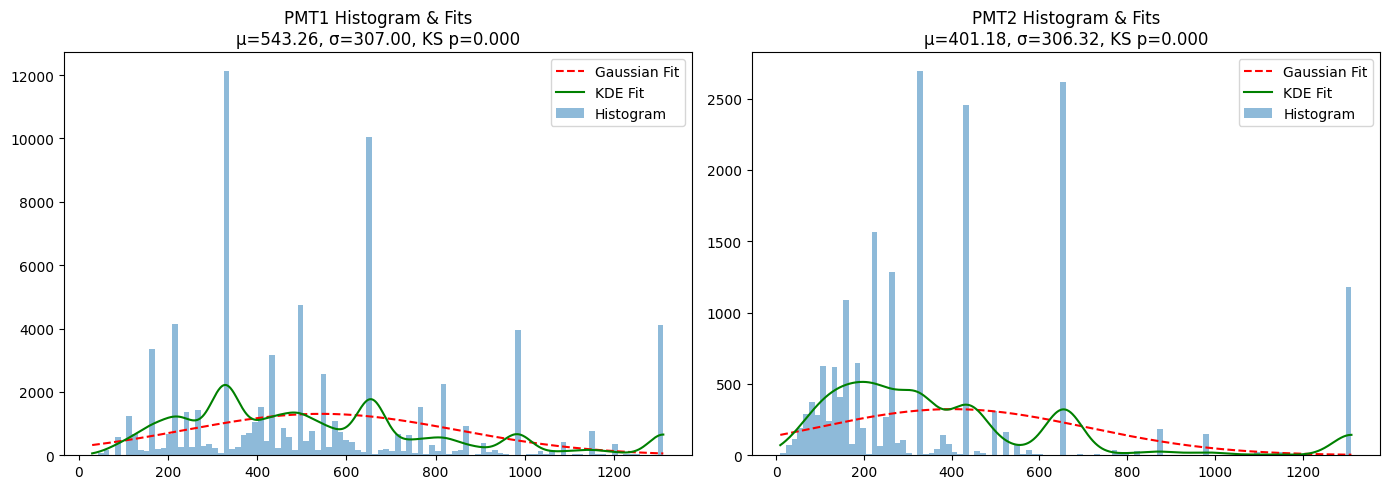

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde, kstest
from scipy.signal import find_peaks

# Flatten and filter non-zero pixels
non_zero_pmt1 = bias_map_pmt1[bias_map_pmt1 > 0].astype(np.float32)
non_zero_pmt2 = bias_map_pmt2[bias_map_pmt2 > 0].astype(np.float32)

# Option: Clip values at 95th percentile instead of removing
p95_pmt1 = np.percentile(non_zero_pmt1, 95)
p95_pmt2 = np.percentile(non_zero_pmt2, 95)

filtered_pmt1 = np.clip(non_zero_pmt1, a_min=None, a_max=p95_pmt1)
filtered_pmt2 = np.clip(non_zero_pmt2, a_min=None, a_max=p95_pmt2)

# Histogram bin setup
num_bins = 100
hist1, bin_edges1 = np.histogram(filtered_pmt1, bins=num_bins)
hist2, bin_edges2 = np.histogram(filtered_pmt2, bins=num_bins)
bin_centers1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2

# Gaussian KDE
kde1 = gaussian_kde(filtered_pmt1)
kde2 = gaussian_kde(filtered_pmt2)

x1 = np.linspace(filtered_pmt1.min(), filtered_pmt1.max(), 1000)
x2 = np.linspace(filtered_pmt2.min(), filtered_pmt2.max(), 1000)

# PDF from KDE scaled to histogram area
pdf_kde1 = kde1(x1) * len(filtered_pmt1) * (bin_edges1[1] - bin_edges1[0])
pdf_kde2 = kde2(x2) * len(filtered_pmt2) * (bin_edges2[1] - bin_edges2[0])

# Gaussian fit parameters
mu1, std1 = norm.fit(filtered_pmt1)
mu2, std2 = norm.fit(filtered_pmt2)
pdf1 = norm.pdf(x1, mu1, std1) * len(filtered_pmt1) * (bin_edges1[1] - bin_edges1[0])
pdf2 = norm.pdf(x2, mu2, std2) * len(filtered_pmt2) * (bin_edges2[1] - bin_edges2[0])

# KS Test
ks_stat1, ks_p1 = kstest(filtered_pmt1, 'norm', args=(mu1, std1))
ks_stat2, ks_p2 = kstest(filtered_pmt2, 'norm', args=(mu2, std2))

print(f"PMT1 KS Test: D={ks_stat1:.3f}, p={ks_p1:.3f}")
print(f"PMT2 KS Test: D={ks_stat2:.3f}, p={ks_p2:.3f}")

# Peak detection (possible structured noise)
peaks1, _ = find_peaks(hist1, height=np.max(hist1)*0.1)
peaks2, _ = find_peaks(hist2, height=np.max(hist2)*0.1)
print(f"PMT1 Peak Positions: {bin_centers1[peaks1]}")
print(f"PMT2 Peak Positions: {bin_centers2[peaks2]}")

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].bar(bin_centers1, hist1, width=(bin_edges1[1] - bin_edges1[0]), alpha=0.5, label='Histogram')
axs[0].plot(x1, pdf1, 'r--', label='Gaussian Fit')
axs[0].plot(x1, pdf_kde1, 'g-', label='KDE Fit')
axs[0].set_title(f'PMT1 Histogram & Fits\nμ={mu1:.2f}, σ={std1:.2f}, KS p={ks_p1:.3f}')
axs[0].legend()
# axs[0].set_yscale("log")  # Uncomment for log scale

axs[1].bar(bin_centers2, hist2, width=(bin_edges2[1] - bin_edges2[0]), alpha=0.5, label='Histogram')
axs[1].plot(x2, pdf2, 'r--', label='Gaussian Fit')
axs[1].plot(x2, pdf_kde2, 'g-', label='KDE Fit')
axs[1].set_title(f'PMT2 Histogram & Fits\nμ={mu2:.2f}, σ={std2:.2f}, KS p={ks_p2:.3f}')
axs[1].legend()
# axs[1].set_yscale("log")  # Uncomment for log scale

plt.tight_layout()
plt.show()

A low p-value (< 0.05) for KS test means that we reject the null hypothesis (that the data is Gaussian).

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.stats import norm

# New structured folder created by your script
base_folder = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/structured_darkframes_endoscopic_scans'

# Get all ROI folders
roi_folders = sorted([
    d for d in os.listdir(base_folder)
    if os.path.isdir(os.path.join(base_folder, d)) and d.startswith('ROI_')
])

pmt1_vals = []
pmt2_vals = []

for roi in roi_folders:
    roi_path = os.path.join(base_folder, roi)
    files = os.listdir(roi_path)

    # Look for PMT1 and PMT2 files using end-match
    pmt1_file = next(f for f in files if f.endswith('-PMT1.tiff'))
    pmt2_file = next(f for f in files if f.endswith('-PMT2.tiff'))

    # Load and flatten
    pmt1_img = np.array(Image.open(os.path.join(roi_path, pmt1_file))).flatten()
    pmt2_img = np.array(Image.open(os.path.join(roi_path, pmt2_file))).flatten()

    pmt1_vals.append(pmt1_img)
    pmt2_vals.append(pmt2_img)

# Combine all values
pmt1_all = np.concatenate(pmt1_vals)
pmt2_all = np.concatenate(pmt2_vals)

print("Loaded and flattened PMT1 and PMT2 data from all ROI folders.")

# Compute histogram and fit Gaussian
def identify_artifact_bins(pixel_values, bin_width=10, z_thresh=4):
    hist, bins = np.histogram(pixel_values, bins=np.arange(0, pixel_values.max(), bin_width))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    mu, sigma = norm.fit(pixel_values)
    expected = norm.pdf(bin_centers, mu, sigma) * len(pixel_values) * bin_width
    artifacts = bin_centers[(hist - expected) > z_thresh * np.sqrt(expected)]
    return artifacts

artifact_bins_pmt1 = identify_artifact_bins(pmt1_all)
artifact_bins_pmt2 = identify_artifact_bins(pmt2_all)

# Mask and Save Corrected Images
def mask_artifacts(img, artifact_bins, bin_width=10):
    for b in artifact_bins:
        img[(img >= b - bin_width/2) & (img <= b + bin_width/2)] = 0
    return img

output_folder = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/output_masked'
os.makedirs(output_folder, exist_ok=True)

for roi in roi_folders:
    roi_path = os.path.join(base_folder, roi)
    files = os.listdir(roi_path)
    pmt1_file = next(f for f in files if f.endswith('-PMT1.tiff'))
    pmt2_file = next(f for f in files if f.endswith('-PMT2.tiff'))
    pmt1_path = os.path.join(roi_path, pmt1_file)
    pmt2_path = os.path.join(roi_path, pmt2_file)

    img1 = np.array(Image.open(pmt1_path)).astype(np.float32)
    img2 = np.array(Image.open(pmt2_path)).astype(np.float32)

    masked1 = mask_artifacts(img1.copy(), artifact_bins_pmt1)
    masked2 = mask_artifacts(img2.copy(), artifact_bins_pmt2)

    Image.fromarray(masked1.astype(np.uint16)).save(os.path.join(output_folder, f"{roi}_pmt1_masked.tiff"))
    Image.fromarray(masked2.astype(np.uint16)).save(os.path.join(output_folder, f"{roi}_pmt2_masked.tiff"))


Loaded and flattened PMT1 and PMT2 data from all ROI folders.


Filtered PMT1 - Min: 24.27, Max: 1310.70
Filtered PMT2 - Min: 9.62, Max: 1310.70


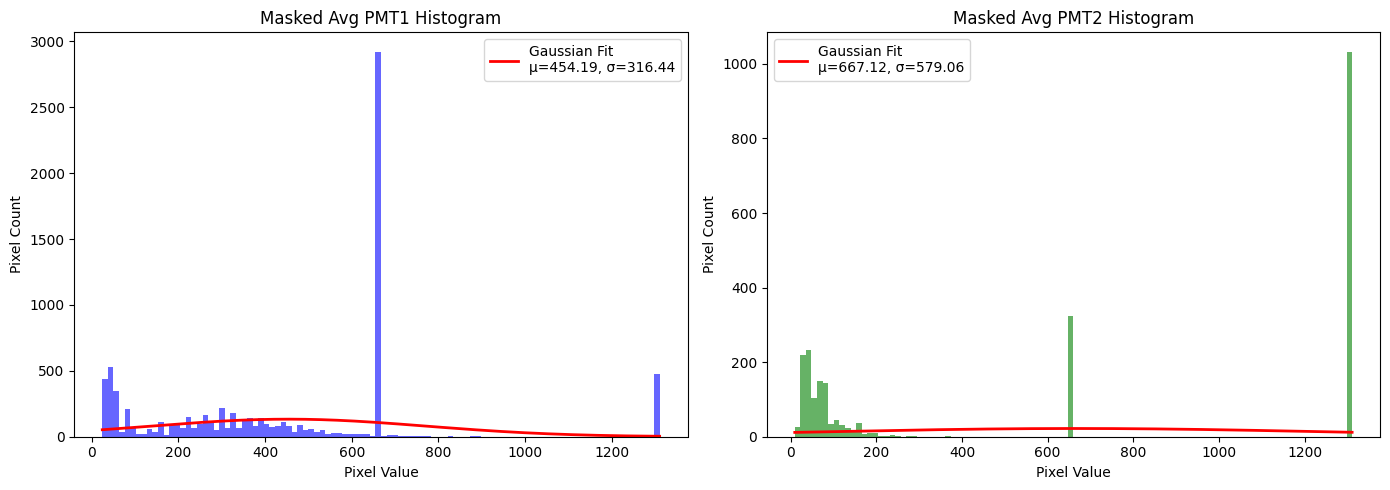

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import norm

# Paths
masked_folder = '/Users/alliyaparvez/Documents/canc_img_denois_s25/dataset/output_masked'

# Reconstruct the original ROI folder names: ROI_1, ROI_2, ...
num_rois = 100  # adjust if needed
roi_names = [f'ROI_{i}' for i in range(1, num_rois + 1)]

pmt1_stack = []
pmt2_stack = []

for roi in roi_names:
    pmt1_path = os.path.join(masked_folder, f'{roi}_pmt1_masked.tiff')
    pmt2_path = os.path.join(masked_folder, f'{roi}_pmt2_masked.tiff')

    if not os.path.exists(pmt1_path) or not os.path.exists(pmt2_path):
        print(f"Missing file(s) for {roi}, skipping...")
        continue

    pmt1_img = np.array(Image.open(pmt1_path)).astype(np.float32)
    pmt2_img = np.array(Image.open(pmt2_path)).astype(np.float32)

    pmt1_stack.append(pmt1_img)
    pmt2_stack.append(pmt2_img)

# Compute average maps
bias_map_pmt1 = np.mean(pmt1_stack, axis=0)
bias_map_pmt2 = np.mean(pmt2_stack, axis=0)

# --- Histogram and Gaussian Fit ---
non_zero_pmt1 = bias_map_pmt1[bias_map_pmt1 > 0].flatten()
non_zero_pmt2 = bias_map_pmt2[bias_map_pmt2 > 0].flatten()

p95_pmt1 = np.percentile(non_zero_pmt1, 95)
p95_pmt2 = np.percentile(non_zero_pmt2, 95)

filtered_pmt1 = non_zero_pmt1[non_zero_pmt1 <= p95_pmt1]
filtered_pmt2 = non_zero_pmt2[non_zero_pmt2 <= p95_pmt2]

min_pmt1, max_pmt1 = filtered_pmt1.min(), filtered_pmt1.max()
min_pmt2, max_pmt2 = filtered_pmt2.min(), filtered_pmt2.max()

print(f"Filtered PMT1 - Min: {min_pmt1:.2f}, Max: {max_pmt1:.2f}")
print(f"Filtered PMT2 - Min: {min_pmt2:.2f}, Max: {max_pmt2:.2f}")

bins = 100
mu1, std1 = norm.fit(filtered_pmt1)
mu2, std2 = norm.fit(filtered_pmt2)

hist1, bin_edges1 = np.histogram(filtered_pmt1, bins=bins, range=(min_pmt1, max_pmt1))
hist2, bin_edges2 = np.histogram(filtered_pmt2, bins=bins, range=(min_pmt2, max_pmt2))

bin_centers1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
bin_centers2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

x1 = np.linspace(min_pmt1, max_pmt1, 1000)
x2 = np.linspace(min_pmt2, max_pmt2, 1000)

pdf1 = norm.pdf(x1, mu1, std1) * len(filtered_pmt1) * (bin_edges1[1] - bin_edges1[0])
pdf2 = norm.pdf(x2, mu2, std2) * len(filtered_pmt2) * (bin_edges2[1] - bin_edges2[0])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(bin_centers1, hist1, width=(max_pmt1 - min_pmt1) / bins, color='blue', alpha=0.6)
axs[0].plot(x1, pdf1, 'r-', linewidth=2, label=f'Gaussian Fit\nμ={mu1:.2f}, σ={std1:.2f}')
axs[0].set_title("Masked Avg PMT1 Histogram")
axs[0].set_xlabel("Pixel Value")
axs[0].set_ylabel("Pixel Count")
axs[0].legend()

axs[1].bar(bin_centers2, hist2, width=(max_pmt2 - min_pmt2) / bins, color='green', alpha=0.6)
axs[1].plot(x2, pdf2, 'r-', linewidth=2, label=f'Gaussian Fit\nμ={mu2:.2f}, σ={std2:.2f}')
axs[1].set_title("Masked Avg PMT2 Histogram")
axs[1].set_xlabel("Pixel Value")
axs[1].set_ylabel("Pixel Count")
axs[1].legend()

plt.tight_layout()
plt.show()


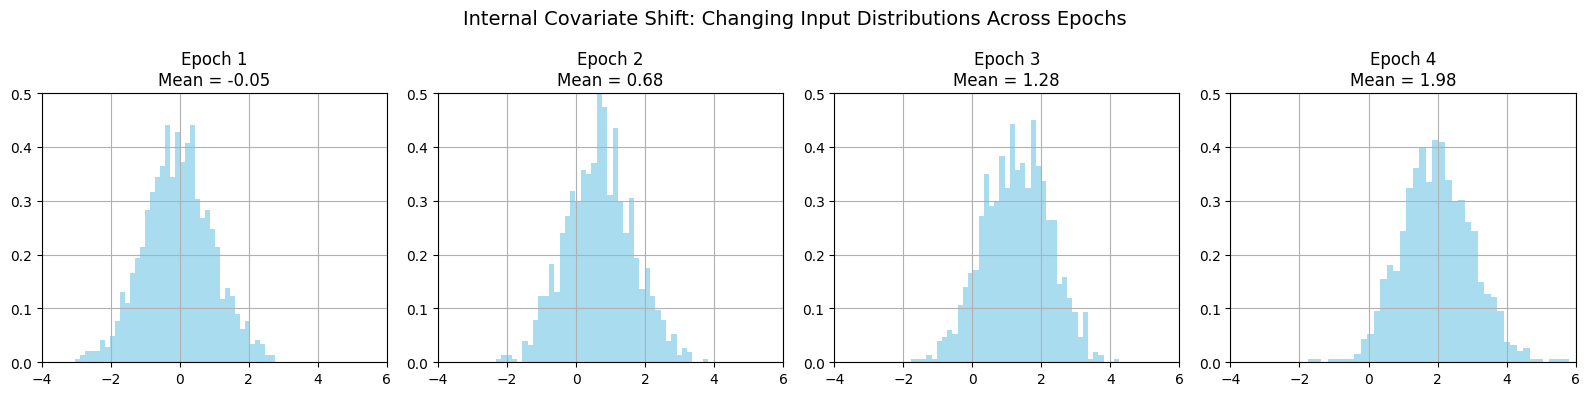

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate internal covariate shift: distributions changing across epochs
np.random.seed(0)
epochs = 4
x = np.linspace(-3, 3, 1000)
distributions = [np.random.normal(loc=mean, scale=1.0, size=1000) for mean in np.linspace(0, 2, epochs)]

# Plot changing distributions (simulating input to a layer across epochs)
fig, axs = plt.subplots(1, epochs, figsize=(16, 4))
for i, data in enumerate(distributions):
    axs[i].hist(data, bins=40, density=True, alpha=0.7, color='skyblue')
    axs[i].set_title(f"Epoch {i+1}\nMean = {np.mean(data):.2f}")
    axs[i].set_xlim(-4, 6)
    axs[i].set_ylim(0, 0.5)
    axs[i].grid(True)

fig.suptitle("Internal Covariate Shift: Changing Input Distributions Across Epochs", fontsize=14)
plt.tight_layout()
plt.show()
